In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os

In [2]:
def discrete_cmap():
    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3']
    cmap3 = colors.ListedColormap(cpool, 'rooms')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'icons')
    cm.register_cmap(cmap=cmap3)

    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3', 'd3d5d7']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)
discrete_cmap()

/tmp/ipykernel_2312/2660030060.py:28: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


In [4]:
data_path = '../../CubiCasa5k/data/cubicasa5k/'
with open(data_path + 'test.txt') as f: files = [f'{data_path}{n[:-1]}F1_original.png'  for n in f.readlines()]
print('\n'.join(f'{i}, {f}' for i,f in enumerate(files[:10])))

0, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/1191/F1_original.png
1, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2536/F1_original.png
2, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2530/F1_original.png
3, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2504/F1_original.png
4, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2207/F1_original.png
5, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/22/F1_original.png
6, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2090/F1_original.png
7, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2085/F1_original.png
8, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2014/F1_original.png
9, ../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2011/F1_original.png


../../CubiCasa5k/data/cubicasa5k//high_quality_architectural/2530/F1_original.png


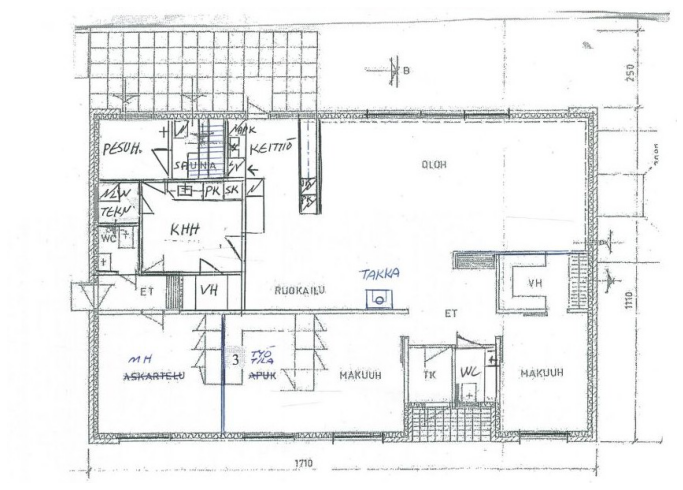

In [5]:
image_name = 'primary-government.png'
path = f'./qualitative/{image_name.split("/")[-1].split(".")[0]}/'

image_name = files[2]
path = f'./qualitative/{"-".join(image_name.split("/")[-3:-1])}/'
print(image_name)
os.makedirs(path, exist_ok=True)

original = cv2.imread(image_name)
try:
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
except:
    original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(12,12))
plt.axis('off')

plt.imshow(original)
plt.savefig(path + 'original.png', bbox_inches='tight', pad_inches=0)

# from segmentation import predict
# rooms_pred, icons_pred, heatmaps = predict(original)

In [11]:
from brute_force import recognize
from recognition import *
import time

verbose = True
with open('./qualitative/all_times.csv', 'w') as f: f.write('area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total\n')

for image_name in tqdm(files[:100]):
    path = f'./qualitative/{"-".join(image_name.split("/")[-3:-1])}/'
    original = cv2.imread(image_name)
    try:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    except:
        original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)

    with open('./qualitative/all_times.csv', 'a') as f:
        prediction = recognize(original, verbose)
        f.write(f'{original.shape[0]*original.shape[1]},')
        f.write(f'{prediction["times"]["segmentation"]},')
        f.write(f'{prediction["times"]["vectorization"]},')

        walls, doors, windows, segmentation = prediction['walls'], prediction['doors'], prediction['windows'], prediction['segmentation']

        start = time.perf_counter()
        walls = attach_openings(walls, doors + windows, verbose)
        attach_time = time.perf_counter() - start

        start = time.perf_counter()
        walls = calculate_wall_widths(walls, prediction['segmentation']['walls'], verbose)
        wall_width_time = time.perf_counter() - start
        f.write(f'{wall_width_time},')

        start = time.perf_counter()
        walls = normalize_wall_points(walls, 5)
        normalize_time = time.perf_counter() - start

        start = time.perf_counter()
        walls = classify_wall_elements(walls, original, verbose)
        symbols = classify_symbols(prediction['symbols'], original, verbose)
        symbol_class_time = time.perf_counter() - start
        f.write(f'{symbol_class_time},')

        f.write(f'{attach_time},{normalize_time},{attach_time+normalize_time},')

        total_time = prediction["times"]["segmentation"] + prediction["times"]["vectorization"]+attach_time+wall_width_time+normalize_time+symbol_class_time
        f.write(f'{total_time}\n')

    res = {'walls': walls, 'symbols': symbols}



100%|██████████| 100/100 [23:46<00:00, 14.27s/it]


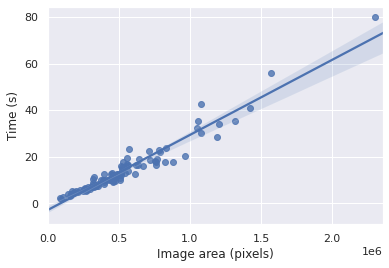

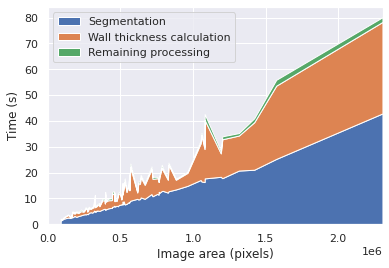

In [64]:
import pandas as pd
import seaborn as sns

sns.set_theme()

times = pd.read_csv('./qualitative/all_times.csv')
times.sort_values(by='area', inplace=True)

sns.regplot(x='area', y='total', data=times, label='Total', truncate=False)
# sns.regplot(x='area', y='seg', data=times, label='Segmentation')
# sns.regplot(x='area', y='vect', data=times, label='Vectorization')
# sns.regplot(x='area', y='wall_width', data=times, label='Wall width')
# plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.xlim([0, times.area.max()+0.05e6])
plt.savefig('./qualitative/time-by-area.pdf')
plt.show()

remaining = times.vect + times["att+norm"] + times.smbl_class

plt.stackplot(
    times.area, times.seg, times.wall_width, remaining, 
    labels=['Segmentation', 'Wall thickness calculation', 'Remaining processing'])
plt.legend(loc='upper left')
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.xlim([0, times.area.max()])
plt.savefig('./qualitative/stacked-time-by-area.pdf')

In [63]:
times["seg/total"] = times.seg/times.total * 100
times["width/total"] = times.wall_width/times.total * 100
times["smbl_class/total"] = times.smbl_class/times.total * 100
times["remaining/total"] = remaining/times.total * 100
times.describe()

,area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total,seg/total,width/total,remaining/total,smbl_class/total
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.306694e+05,8.283212,0.264909,5.255502,0.358446,0.037199,0.003877,0.041076,14.203145,62.457073,32.020832,5.522095,3.352648
std,3.459682e+05,5.804368,0.264502,5.675655,0.155211,0.026666,0.001658,0.027451,11.547165,9.755045,9.826225,2.169942,1.799781
min,8.958500e+04,1.455169,0.014641,0.134477,0.035721,0.006253,0.001543,0.008754,1.873386,38.871519,7.178261,1.467609,0.523802
25%,3.190360e+05,4.924208,0.098322,1.912348,0.251679,0.020896,0.002619,0.025106,7.172234,55.690288,24.731639,4.135444,2.012899
50%,4.611110e+05,7.033496,0.165284,3.753510,0.339416,0.029819,0.003642,0.033654,11.669191,62.800126,32.734114,5.291064,3.111468
75%,6.266678e+05,9.777467,0.334985,6.073796,0.440523,0.045093,0.004679,0.049427,16.922880,68.987134,38.557967,6.780256,4.448635
max,2.304224e+06,42.901142,1.389730,35.410701,0.855667,0.181324,0.010136,0.189040,80.132280,89.015053,54.956154,15.140161,11.425521


In [6]:
from brute_force import recognize
from recognition import *
import time

with open(path + 'times.txt', 'w') as f:
    prediction = recognize(original, verbose)
    f.write('task,time\n')
    f.write(f'area,{original.shape[0]*original.shape[1]}\n')
    f.write(f'segmentation,{prediction["times"]["segmentation"]}\n')
    f.write(f'vectorization,{prediction["times"]["vectorization"]}\n')

    walls, doors, windows, segmentation = prediction['walls'], prediction['doors'], prediction['windows'], prediction['segmentation']

    start = time.perf_counter()
    walls = attach_openings(walls, doors + windows, verbose)
    attach_time = time.perf_counter() - start

    start = time.perf_counter()
    walls = calculate_wall_widths(walls, prediction['segmentation']['walls'], verbose)
    wall_width_time = time.perf_counter() - start
    f.write(f'wall width,{wall_width_time}\n')

    start = time.perf_counter()
    walls = normalize_wall_points(walls, 5)
    normalize_time = time.perf_counter() - start

    start = time.perf_counter()
    walls = classify_wall_elements(walls, original, verbose)
    symbols = classify_symbols(prediction['symbols'], original, verbose)
    symbol_class_time = time.perf_counter() - start
    f.write(f'symbol classification,{symbol_class_time}\n')

    f.write(f'attach,{attach_time}\n')
    f.write(f'normalize,{normalize_time}\n')
    f.write(f'attach+normalize,{attach_time + normalize_time}\n')

    f.write(f'total,{prediction["times"]["segmentation"] + prediction["times"]["vectorization"]+attach_time+wall_width_time+normalize_time+symbol_class_time}\n')

    res = {'walls': walls, 'symbols': symbols}

/mnt/c/Users/joaodavid/Desktop/practical/Recognition/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 14/14 [00:01<00:00,  8.85it/s]


In [84]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

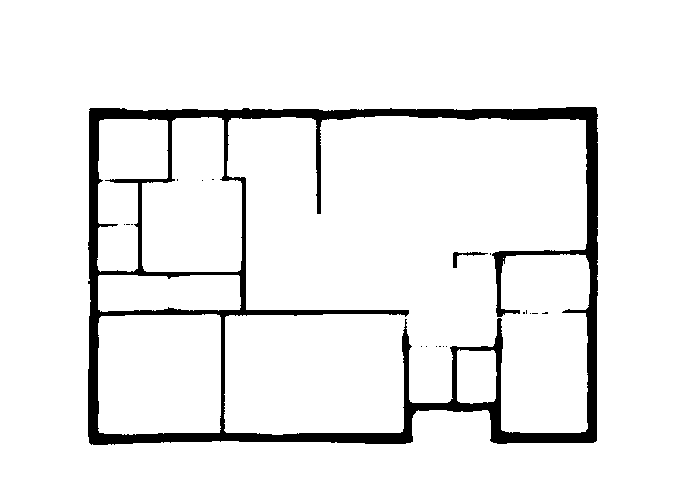

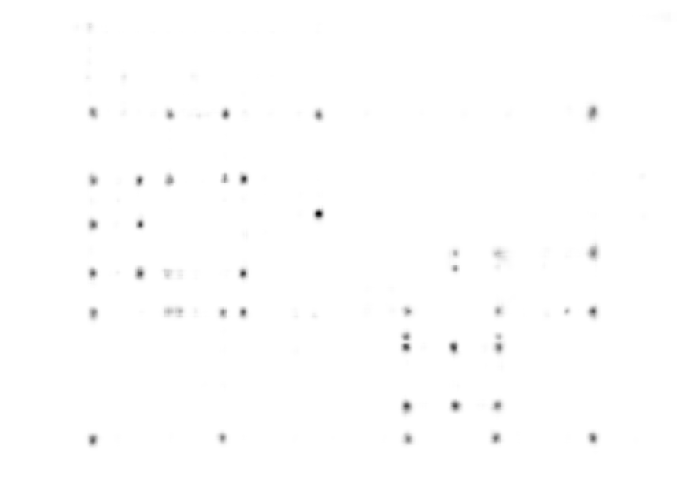

In [85]:
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(~segmentation['walls']//255, cmap='gray', interpolation='none')

plt.savefig(path + 'walls.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(1-segmentation['heatmaps'], cmap='gray', interpolation='none')
plt.savefig(path + 'heatmaps.png', bbox_inches='tight', pad_inches=0)
plt.show()

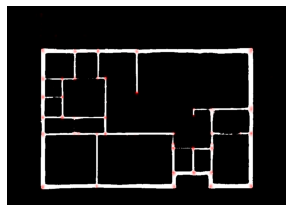

In [86]:
plt.figure(figsize=(5,5))
plt.axis('off')
transparent = cv2.cvtColor(original, cv2.COLOR_RGB2RGBA)
zero = np.zeros_like(transparent)
one = np.ones_like(transparent)

walls = zero.copy()
walls[segmentation['walls'] == 255] = [255, 255, 255, 255]
walls[segmentation['walls'] == 0] = [0, 0, 0, 255]
plt.imshow(walls)

reds = np.intp(np.stack([one[:,:,0]*255, zero[:,:,0], zero[:,:,0], segmentation['heatmaps']*255], axis=-1))
plt.imshow(reds, interpolation='none')

In [87]:
def draw_poly(img, points, colors, thickness):
    img = img.copy()
    for i in range(len(points)):
        p, q = points[i], points[(i+1)%len(points)]
        img = cv2.line(img, p, q, colors[i%len(colors)], thickness)
    return img


/tmp/ipykernel_6667/1673779067.py:17: UserWarning: Trying to register the cmap 'selected_icons' which already exists.
  cm.register_cmap(cmap=cmap1)


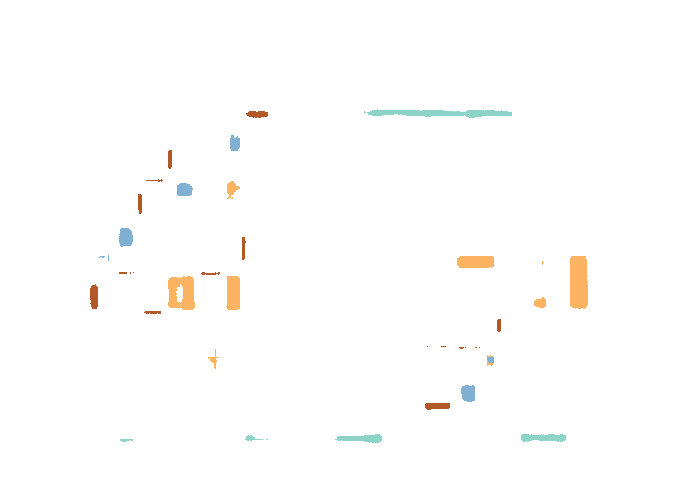

In [88]:
icon_seg = segmentation['icons'].copy()
# walls_closed = as_image(rooms_pred == 2)
# doors_pixels = as_image(icons_pred ==  2)
# windows_pixels = as_image(icons_pred ==  1)
# closets_pixels = as_image(icons_pred == 3)
# toilets_pixels = as_image(icons_pred == 5)
# sinks_pixels = as_image(icons_pred == 6)
# bathtubs_pixels = as_image(icons_pred == 9)

selected = [0, 1, 2, 3, 5, 6, 9]

icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]
cpool = np.array(['#ffffff', '#8dd3c7', '#b15928', '#fdb462', '#ffff99', '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969', '#577a4d'])
# cpool = np.array(['#dcdcdc', '#8dd3c7', '#b15928', '#fdb462', '#ffff99', '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969', '#577a4d'])
cpool = list(cpool[selected])
cmap1 = colors.ListedColormap(cpool, 'selected_icons')
cm.register_cmap(cmap=cmap1)

negation = list(set(range(len(icon_classes))) - set(selected))
to = list(range(0, len(selected)))

for i in range(len(negation)):
    icon_seg[icon_seg == negation[i]] = 0
for i in range(len(selected)):
    icon_seg[icon_seg == selected[i]] = to[i]

selected_icons = list(np.array(icon_classes)[selected])

fig=plt.figure(figsize=(12,12))
ax = plt.axes()
plt.axis('off')
n_icons = len(selected_icons)
iseg = ax.imshow(np.intp(icon_seg), cmap='selected_icons', vmin=0, vmax=n_icons-0.1, interpolation='none')
# cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
# cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, cax=cax)
# cbar.ax.set_yticklabels(selected_icons, fontsize=20)
plt.savefig(path + 'iconsseg.png', bbox_inches='tight', pad_inches=0)

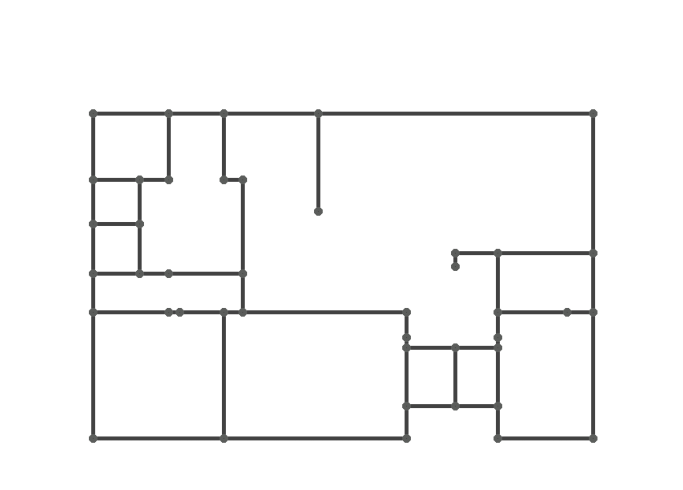

In [89]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'vector.png', bbox_inches='tight', pad_inches=0)

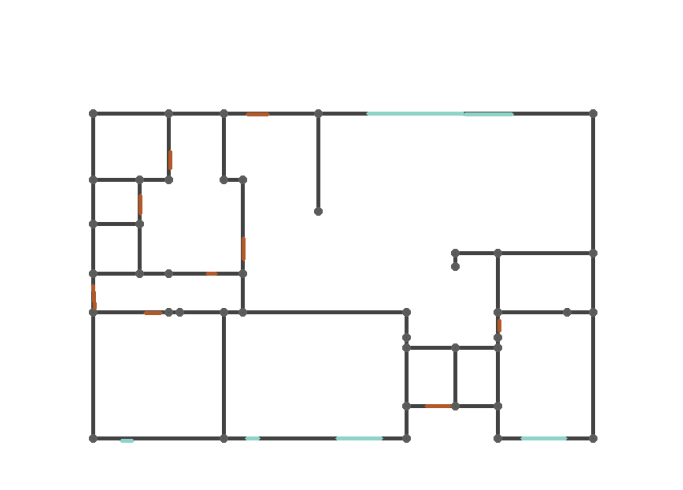

In [90]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)



plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'attached.png', bbox_inches='tight', pad_inches=0)

In [91]:
def to_rgb(hex):
    hex = hex[1:]
    return tuple(tuple(int(hex[i:i+2], 16) for i in (0, 2, 4)))

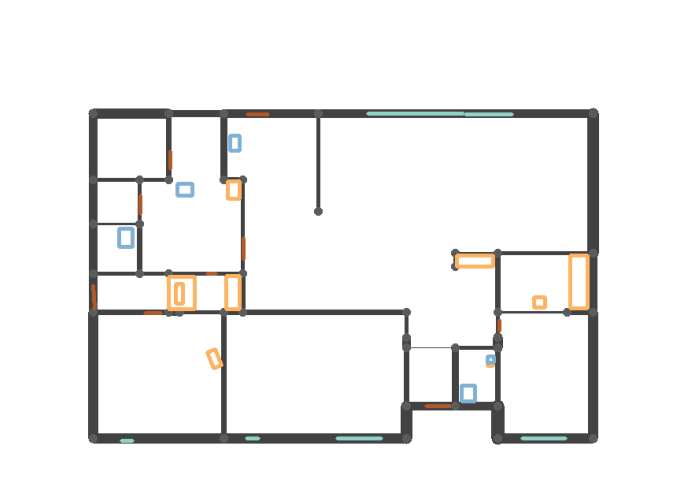

In [92]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), wall["width"])

alpha = 0.5
reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)

# symbols = ('closet', 'toilet', 'sink', 'bathtub')
symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink', 'bathtub']
# colors = ((158, 107, 26), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
symbol_colors = [to_rgb(c) for c in cpool]
for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

# for wall in res['walls']:
#     centroid = np.intp(np.mean(wall['points'], axis=0))
#     reconstr = put_text(reconstr, str(wall['width']), centroid, 0.4)
#     if 'elements' in wall:
#         for el in wall['elements']:
#             if el['type'] == 'door':
#                 centroid = np.intp(np.mean(el['points'], axis=0))
#                 orientation = el['orientation'][-2:]
#                 reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

# for symbol in res['symbols']:
#     if symbol['type'] in ('toilet', 'sink'):
#         centroid = np.intp(np.mean(symbol['points'], axis=0))
#         reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'withicons.png', bbox_inches='tight', pad_inches=0)

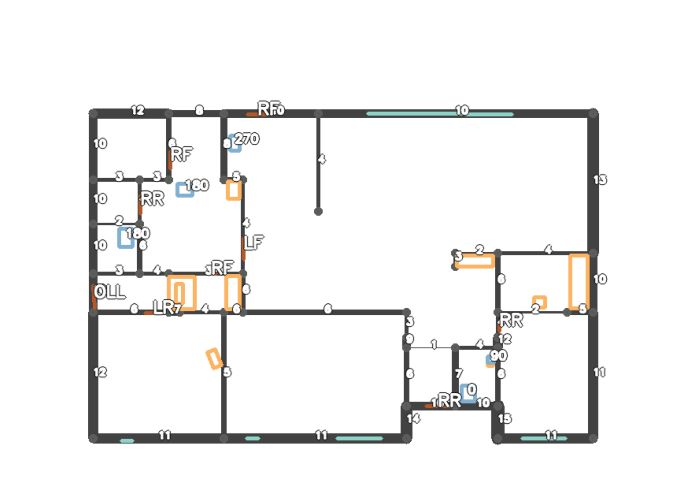

In [93]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), wall["width"])
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), wall["width"])

alpha = 0.5
reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)

# symbols = ('closet', 'toilet', 'sink', 'bathtub')
symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink', 'bathtub']
# colors = ((158, 107, 26), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
symbol_colors = [to_rgb(c) for c in cpool]
for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

for wall in res['walls']:
    centroid = np.intp(np.mean(wall['points'], axis=0))
    reconstr = put_text(reconstr, str(wall['width']), centroid, 0.4)
    if 'elements' in wall:
        for el in wall['elements']:
            if el['type'] == 'door':
                centroid = np.intp(np.mean(el['points'], axis=0))
                orientation = el['orientation'][-2:]
                if 'opposite' in el['orientation']: orientation = 'o' + orientation
                reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

for symbol in res['symbols']:
    if symbol['type'] in ('toilet', 'sink'):
        centroid = np.intp(np.mean(symbol['points'], axis=0))
        reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'allsemantics.png', bbox_inches='tight', pad_inches=0)

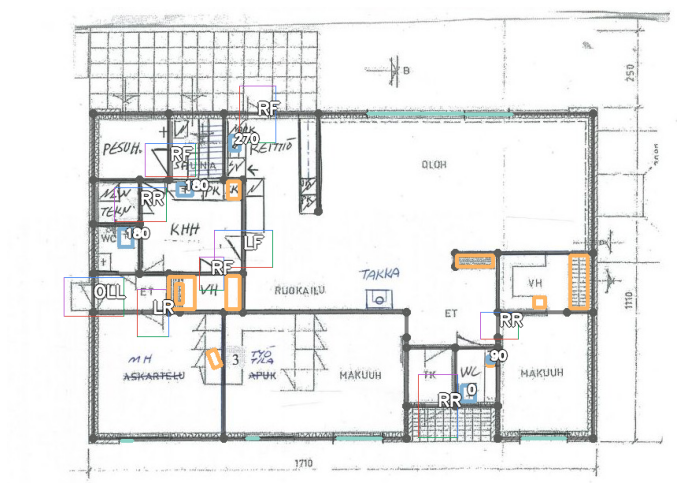

In [94]:
reconstr = np.copy(original)
# reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

alpha = 0.65
reconstr = cv2.addWeighted(reconstr, alpha, original, 1 - alpha, 0)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)
                reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55), (15,157,88), (66,133,244), (186,85,211)), 1)

# symbols = ('closet', 'toilet', 'sink', 'bathtub')
symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink', 'bathtub']
# colors = ((158, 107, 26), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
symbol_colors = [to_rgb(c) for c in cpool]
for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

for wall in res['walls']:
    centroid = np.intp(np.mean(wall['points'], axis=0))
    if 'elements' in wall:
        for el in wall['elements']:
            if el['type'] == 'door':
                centroid = np.intp(np.mean(el['points'], axis=0))
                orientation = el['orientation'][-2:]
                if 'opposite' in el['orientation']: orientation = 'o' + orientation
                reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

for symbol in res['symbols']:
    if symbol['type'] in ('toilet', 'sink'):
        centroid = np.intp(np.mean(symbol['points'], axis=0))
        reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'no_width.png', bbox_inches='tight', pad_inches=0)

In [95]:
def put_text(img, text, pos, size=1, color=(255, 255, 255)):
    img = cv2.putText(
        img, text, pos,
        cv2.FONT_HERSHEY_SIMPLEX, size, (0, 0, 0), thickness=4, lineType=cv2.LINE_AA
    )
    img = cv2.putText(
        img, text, pos,
        cv2.FONT_HERSHEY_SIMPLEX, size, color, thickness=2, lineType=cv2.LINE_AA
    )
    return img

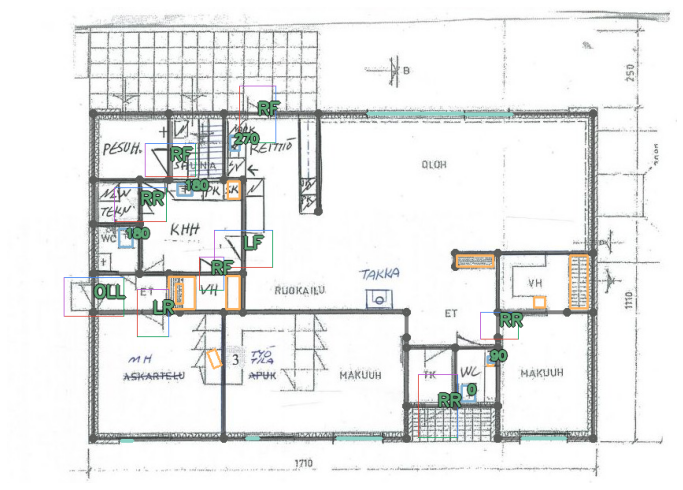

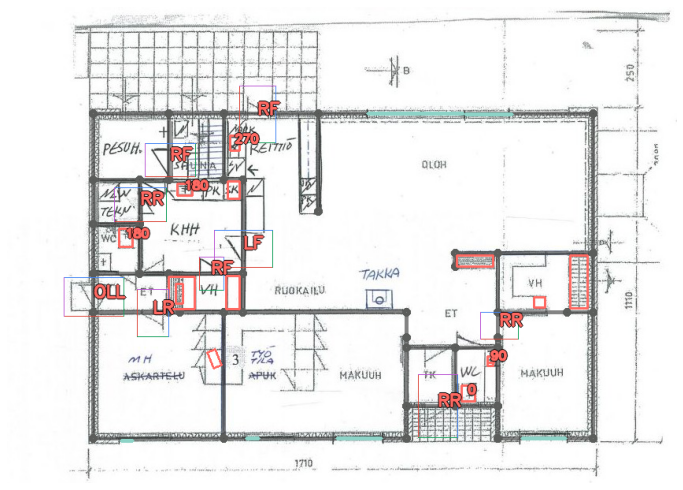

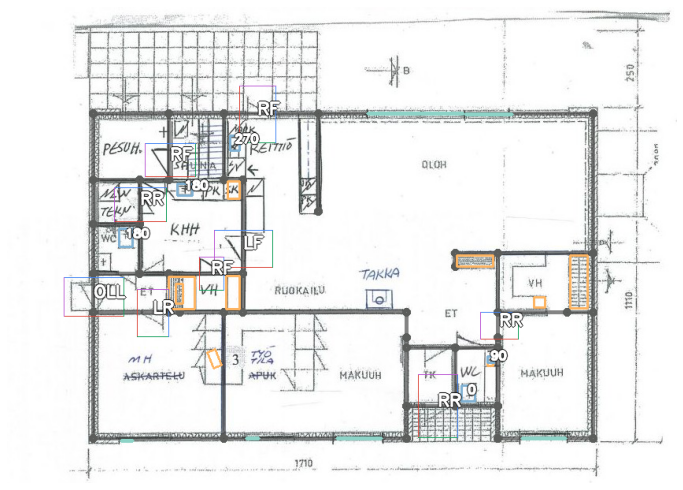

In [96]:

alpha = 0.65

fontcolors = {'green': (95, 167, 119), 'red': (255, 105, 98), 'white': (255,255,255)}

symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink', 'bathtub']
symbol_colors = [to_rgb(c) for c in cpool]

for cname, color in fontcolors.items():
    reconstr = np.copy(original)
    # reconstr = np.full(original.shape, 255).astype(np.uint8)
    for wall in res['walls']:
        s, e = wall['points']
        reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

    reconstr = cv2.addWeighted(reconstr, alpha, original, 1 - alpha, 0)

    for wall in res['walls']:
        s, e = wall['points']
        reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
        reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

    for wall in res['walls']:
        if 'elements' in wall:
            for el in wall['elements']:
                s, e = el['points']
                if el['type'] == 'window':
                    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
                else:
                    # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                    # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)
                    reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55), (15,157,88), (66,133,244), (186,85,211)), 1)

    for symbol in res['symbols']:
        if cname == 'red':
            reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, color, 2)
        else:
            reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 2)

    for wall in res['walls']:
        if 'elements' in wall:
            for el in wall['elements']:
                s, e = el['points']
                if el['type'] == 'door':
                    # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                    # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (255, 0, 0), 1)
                    reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55), (15,157,88), (66,133,244), (186,85,211)), 1)

    for symbol in res['symbols']:
        if symbol['type'] in ('toilet', 'sink'):
            centroid = np.intp(np.mean(symbol['points'], axis=0))
            reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5, color=color)

    for wall in res['walls']:
        centroid = np.intp(np.mean(wall['points'], axis=0))
        if 'elements' in wall:
            for el in wall['elements']:
                if el['type'] == 'door':
                    centroid = np.intp(np.mean(el['points'], axis=0))
                    orientation = el['orientation'][-2:]
                    if 'opposite' in el['orientation']: orientation = 'o' + orientation
                    reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7, color=color)

    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(reconstr)
    plt.savefig(path + f'symbols-{cname}.png', bbox_inches='tight', pad_inches=0)
    plt.show()